In [6]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from data_utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
DATA_DIR = './ADE20K_outdoor/'
x_dir = os.path.join(DATA_DIR, 'images/training')
y_dir = os.path.join(DATA_DIR, 'annotations/training_binary')
class_dir = "./label_class_dict_2.csv"

In [8]:
class_dict = pd.read_csv(class_dir)
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['other', 'sky']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Class indices : ', select_class_indices, )

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['other', 'sky']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]
Class indices :  [0, 1]


In [9]:
# load best saved model checkpoint from the current run
if os.path.exists('./saved_models/best_unet_model.pth'):
    unet_model = torch.load('./saved_models/best_unet_model.pth', map_location=device)
    print('Loaded UNet model from this run.')
else:
    print('No model saved')


Loaded UNet model from this run.


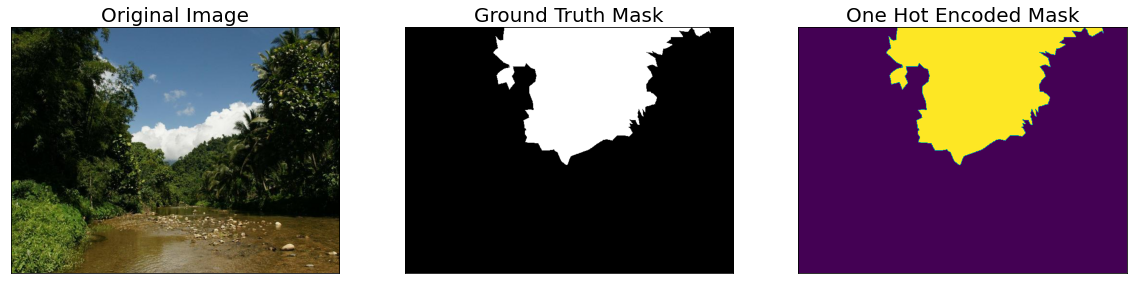

In [10]:
encoder = 'resnet50'
encoder_weights = 'imagenet'
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)
# Get Test-set
(_, _, test_dataset), _ = get_train_val_test_datasets(
        x_dir,
        y_dir,
        select_class_rgb_values,
        preprocessing=get_preprocessing(preprocessing_fn))
test_dataset_vis = get_vis_test_set(x_dir, y_dir, select_class_rgb_values)
# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [25]:
from collections import OrderedDict
def inference(test_dataset, test_dataset_vis, model):
    for idx in range(len(test_dataset)):
        image, gt_mask = test_dataset[idx]
        image_vis = test_dataset_vis[idx][0]
        x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    
        # Predict test image
        pred_mask = model(x_tensor)
        if isinstance(pred_mask, OrderedDict):
            pred_mask = pred_mask['out']
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Get prediction channel corresponding to building
        pred_building_heatmap = pred_mask[:,:,select_classes.index('sky')]
        pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
        # Convert gt_mask from `CHW` format to `HWC` format
        gt_mask = np.transpose(gt_mask,(1,2,0))
        gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
        
        visualize(
            original_image = image_vis,
            ground_truth_mask = gt_mask,
            predicted_mask = pred_mask,
            predicted_building_heatmap = pred_building_heatmap
        )
        if idx==10:
            break

# Unet

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


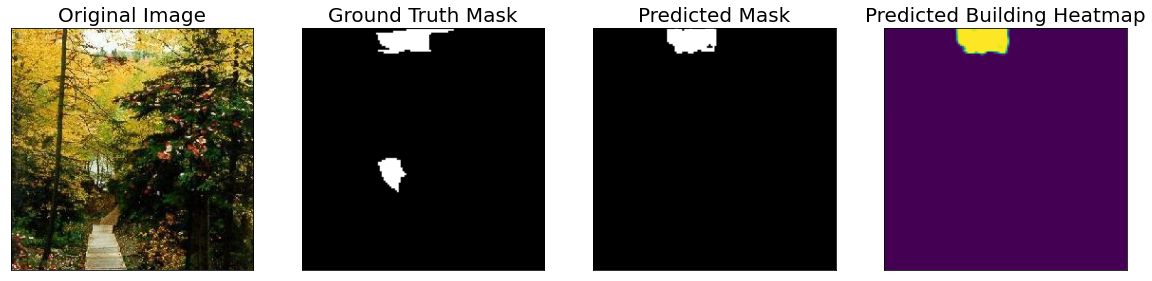

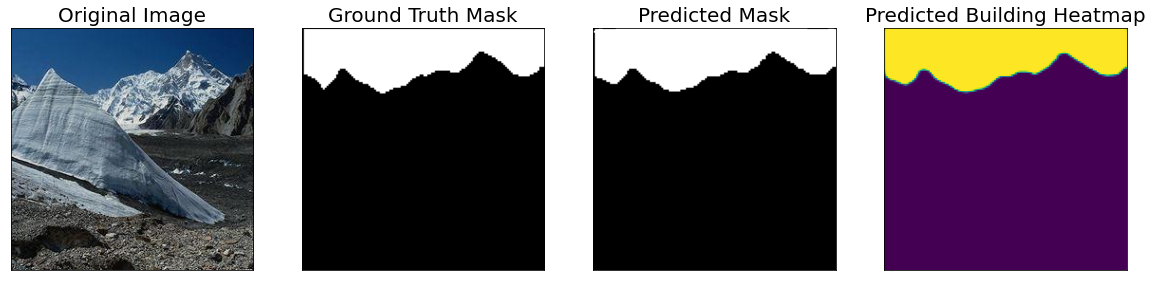

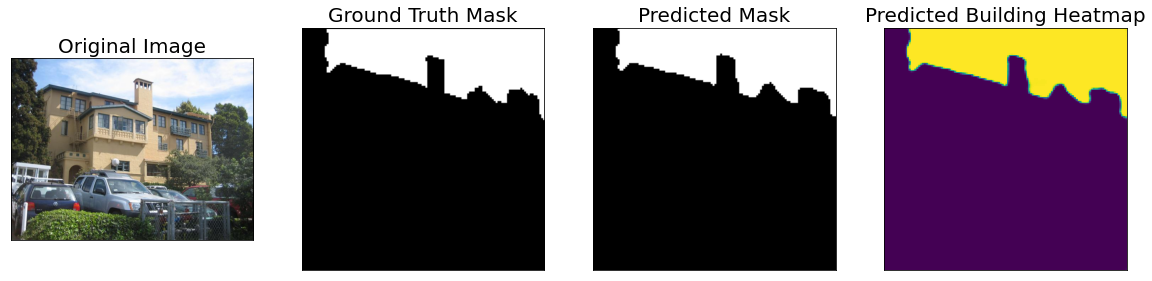

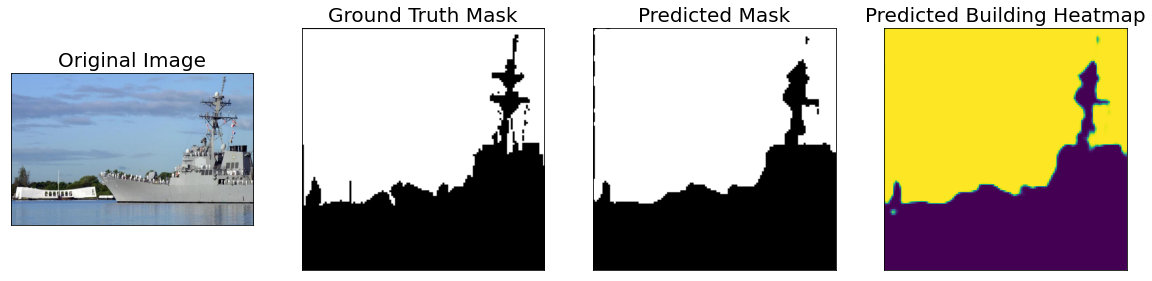

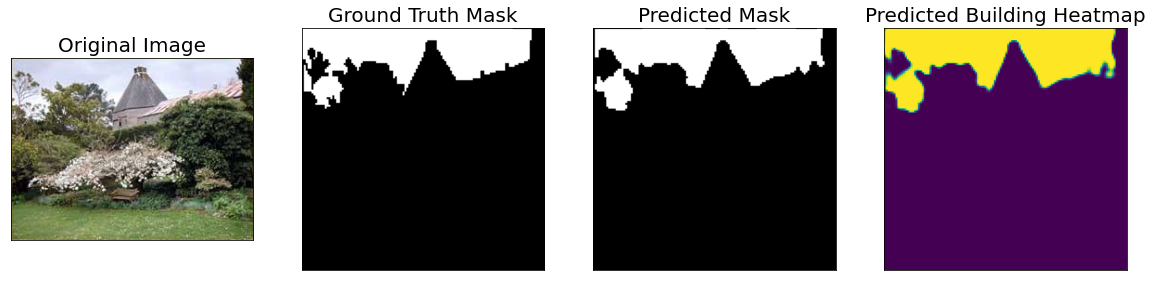

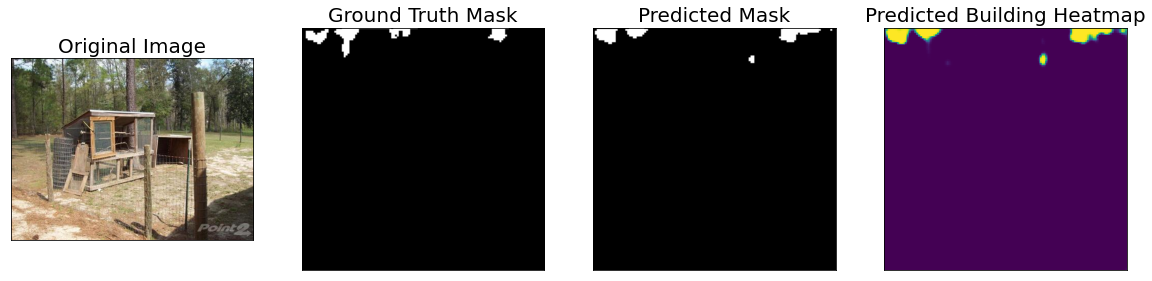

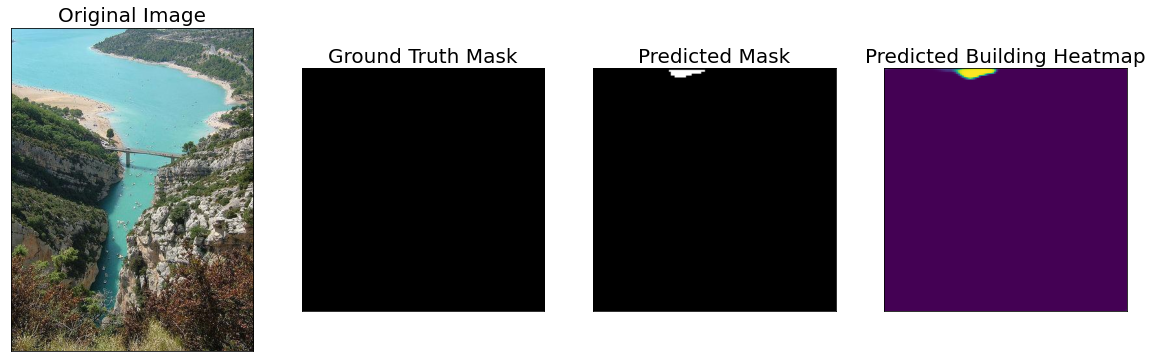

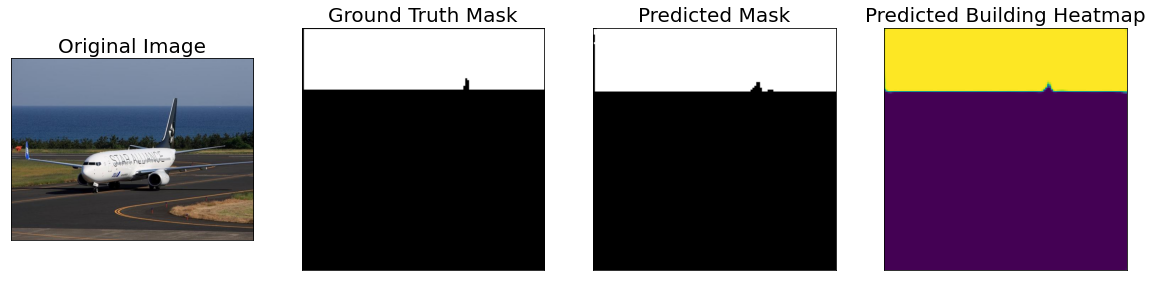

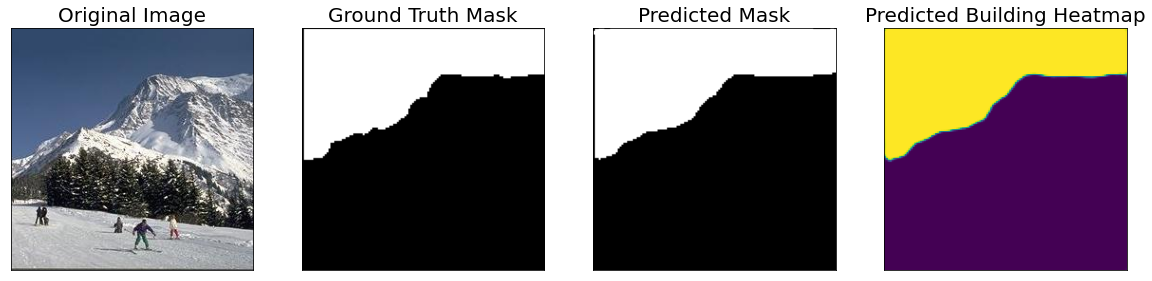

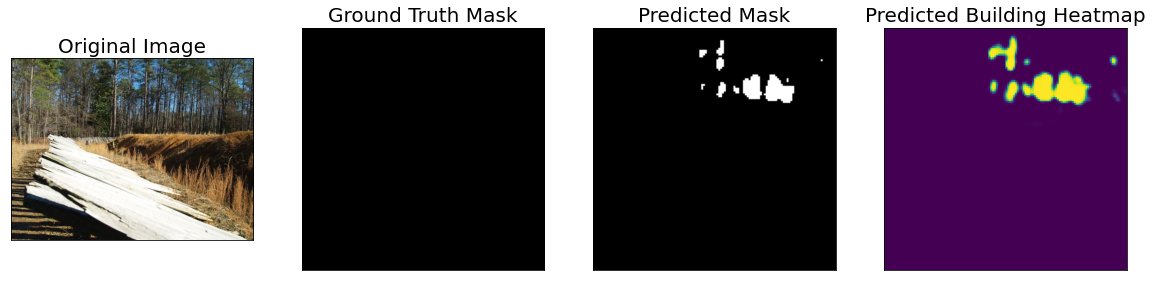

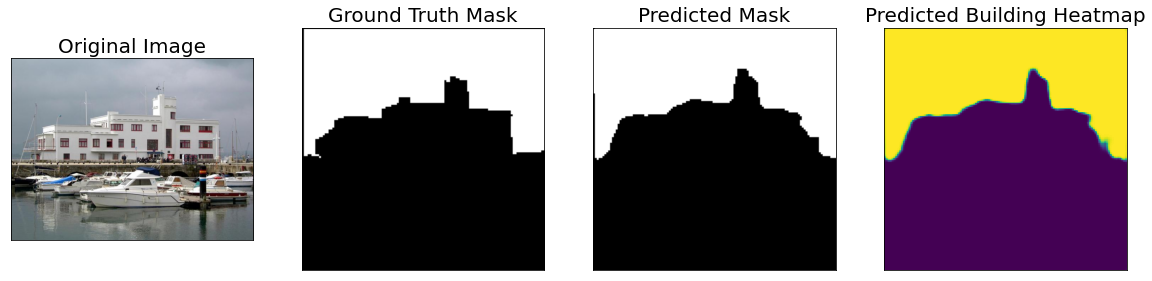

In [12]:
inference(test_dataset, test_dataset_vis, unet_model)

# Deeplabv3

In [16]:
# load best saved model checkpoint from the current run
if os.path.exists('./saved_models/best_deeplabv3_model.pt'):
    deeplabv3_model = torch.load('./saved_models/best_deeplabv3_model.pt', map_location=device)
    print('Loaded UNet model from this run.')
else:
    print('No model saved')

Loaded UNet model from this run.


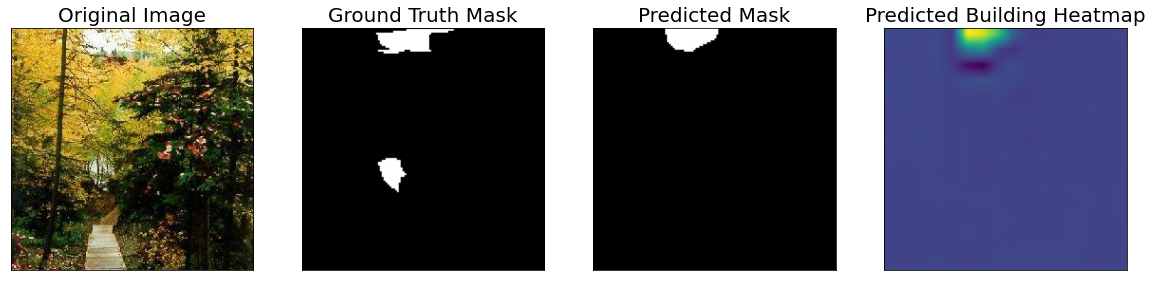

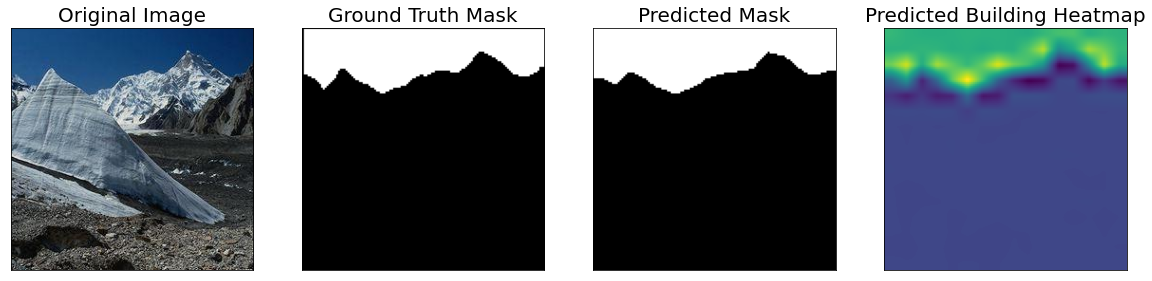

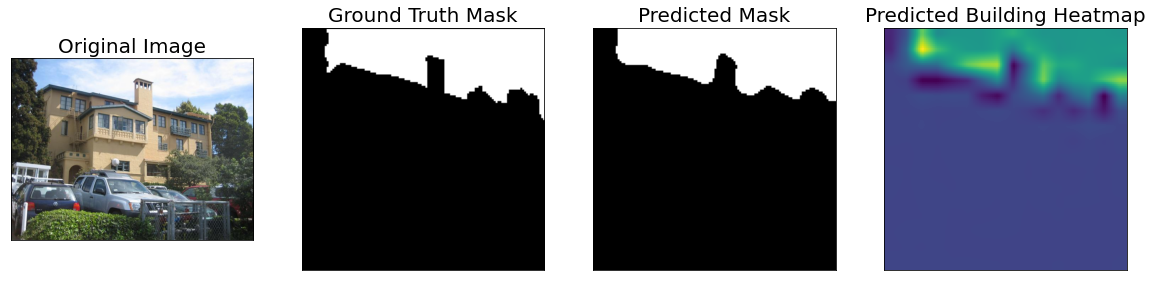

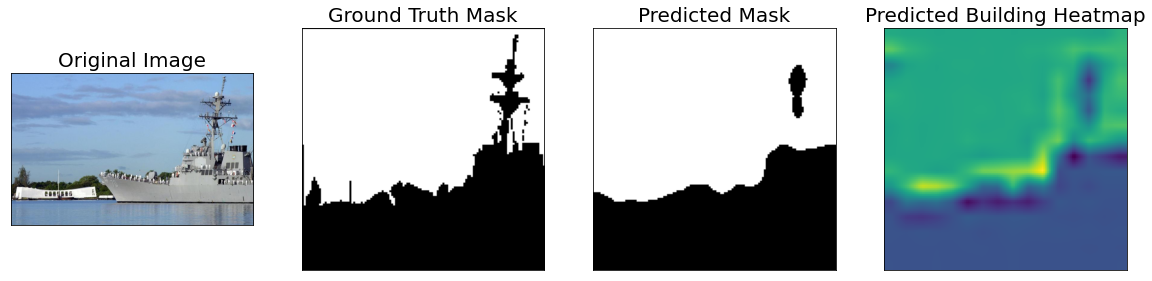

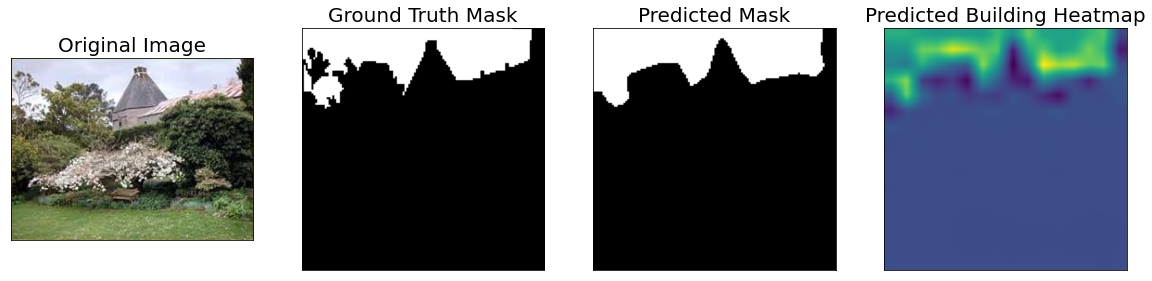

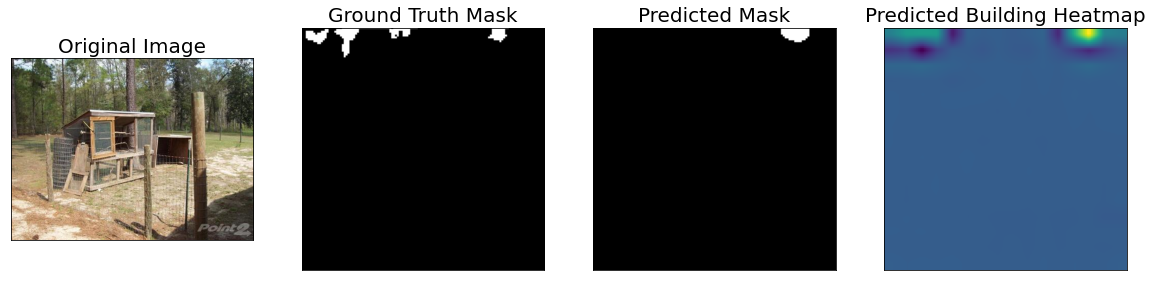

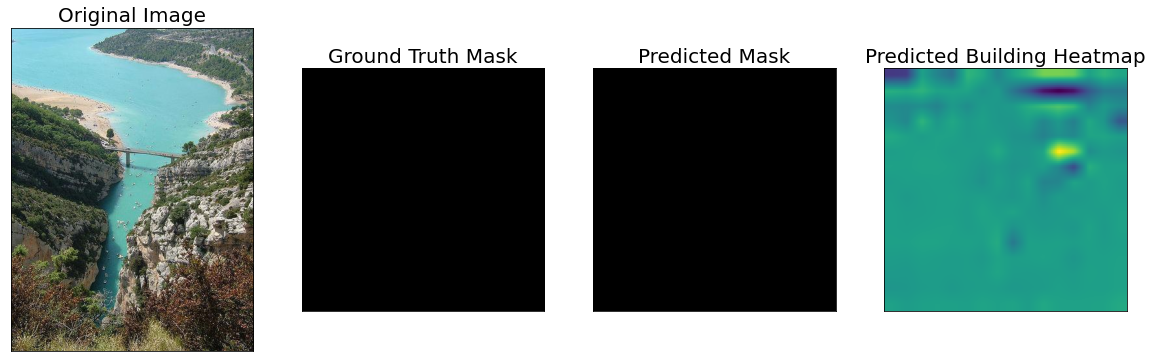

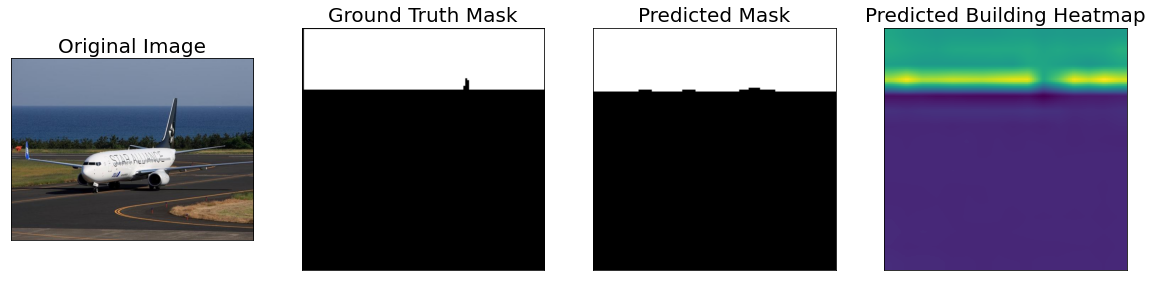

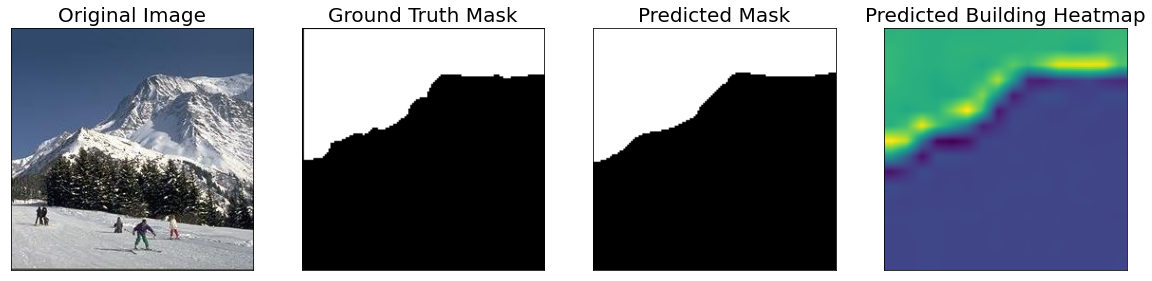

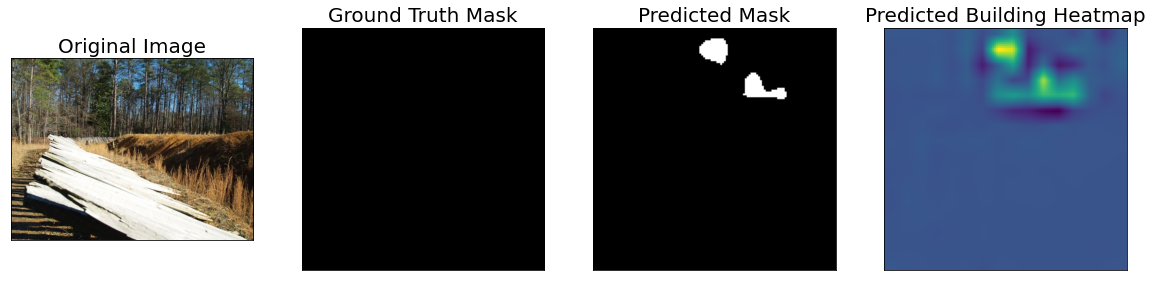

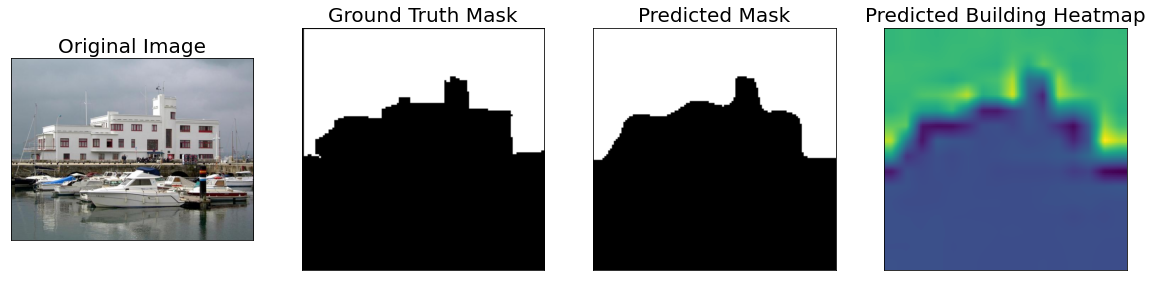

In [45]:
# Get Test-set
(_, _, test_dataset_deeplab), _ = get_train_val_test_datasets(
        x_dir,
        y_dir,
        select_class_rgb_values,
        preprocessing=get_preprocessing())

inference(test_dataset_deeplab, test_dataset_vis, deeplabv3_model)